In [1]:
# LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # Visualization
import seaborn as sb # Visualization
import PIL #Image viewer

# import glob to return all file paths that match a specific pattern
import os
from glob import glob
import itertools

# for Compatibility
from __future__ import print_function, division
from builtins import range, input

# Include tensorflow keras layers, models, and preprocessing

from tensorflow import keras 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Importing confusion matrix to describe the performance of the model
from sklearn.metrics import confusion_matrix

In [2]:
# Include the directories of the dataset
train_path = '../VGG/Fruits_360/fruits-360-original-size/fruits-360-original-size/Training'
valid_path = '../VGG/Fruits_360/fruits-360-original-size/fruits-360-original-size/Validation'

In [3]:
# Get the files from the directories
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
folders = glob(train_path + '/*')

In [4]:
# Check the length of training data
print(len(image_files))

6231


In [5]:
# Check the length of validation data
print(len(valid_image_files))

3114


In [6]:
# Check the number of classes
print(len(folders))

24


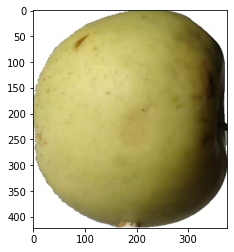

In [7]:
# View a sample image
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [8]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

In [9]:
# training config:
epochs = 3 # Increase the epochs or use callbacks
batch_size = 128

In [10]:
# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [11]:
# if you don't want to train existing weights, set False
# set True to Fine tune
for layer in res.layers:
    layer.trainable = False

In [12]:
# Adding the last layer corresponding to the number of classes.
# Use Softmax for multiclass classifcation
# More hidden layers can be added
x = Flatten()(res.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
# create a model object
model = Model(inputs=res.input, outputs=prediction)

In [14]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

How does ImageDataGenerator works!!

In [16]:
# Create an instance of ImageDataGenerator

train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [17]:
test_gen = val_gen.flow_from_directory(valid_path, target_size = IMAGE_SIZE)
print(test_gen.class_indices)

Found 3114 images belonging to 24 classes.
{'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}


In [18]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

In [19]:
labels

['apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golden_1',
 'apple_golden_2',
 'apple_golden_3',
 'apple_granny_smith_1',
 'apple_hit_1',
 'apple_pink_lady_1',
 'apple_red_1',
 'apple_red_2',
 'apple_red_3',
 'apple_red_delicios_1',
 'apple_red_yellow_1',
 'apple_rotten_1',
 'cabbage_white_1',
 'carrot_1',
 'cucumber_1',
 'cucumber_3',
 'eggplant_violet_1',
 'pear_1',
 'pear_3',
 'zucchini_1',
 'zucchini_dark_1']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -84.68 max: 151.061


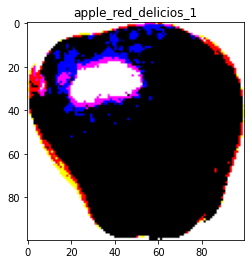

In [20]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [21]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


In [22]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

# rms prop vs Adam


Epoch 1/3
48/48 [==============================] - 81s 2s/step - loss: 1.5802 - accuracy: 0.8004 - val_loss: 0.1103 - val_accuracy: 0.9622
Epoch 2/3
48/48 [==============================] - 79s 2s/step - loss: 0.1111 - accuracy: 0.9717 - val_loss: 0.1008 - val_accuracy: 0.9681
Epoch 3/3
48/48 [==============================] - 78s 2s/step - loss: 0.0558 - accuracy: 0.9843 - val_loss: 0.1064 - val_accuracy: 0.9720


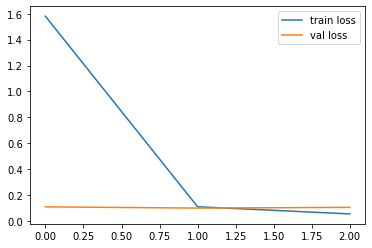

In [23]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

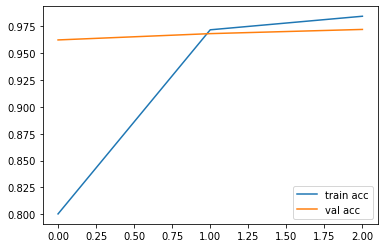

In [24]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [25]:
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [26]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 6231
Found 6231 images belonging to 24 classes.
[[315   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 320   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 318   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 308   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 295   3   1   5   0   0   0   4   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 274   0   6   0   0   0  35   0   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   0   0   0   0   0 320   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 468   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0 312   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  

In [27]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 3114
Found 3114 images belonging to 24 classes.
[[158   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 160   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 154   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 152   0   0   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 136   0   4   0   0   0  18   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 160   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 234   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0 155   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  

Confusion matrix, without normalization
[[315   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 320   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 318   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 308   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 295   3   1   5   0   0   0   4   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 274   0   6   0   0   0  35   0   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   0   0   0   0   0 320   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 468   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0 312   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1 291   0  17  

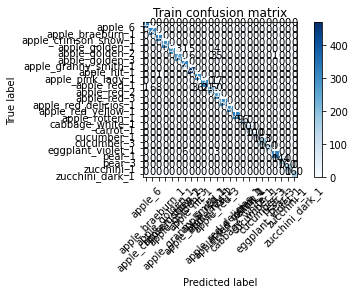

In [28]:
from utils import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, without normalization
[[158   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 160   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 154   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 152   0   0   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 136   0   4   0   0   0  18   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 160   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 234   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0 155   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1 146   0   8  

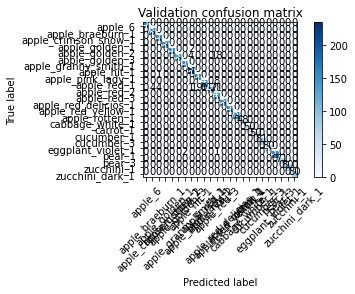

In [29]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [30]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
score = r.model.evaluate(valid_generator)

16/25 [==================>...........] - ETA: 7s - loss: 0.1247 - accuracy: 0.9683

In [ ]:
score

In [ ]:
print(f"Model Accuracy: %{score[1]*100}")

In [ ]:
# r.model.save("./")